# Conditional Residual GAN for Symbolic Melody Generation
by Lorenzo Schiavone, Federico Tamburlin

paper di riferimento:
> MidiNet: A Convolutional Generative Adversarial Network for Symbolic-domain Music Generation, Li-Chia Yang, Szu-Yu Chou, Yi-Hsuan Yang https://arxiv.org/abs/1703.10847





NETWORK STRUCTURE

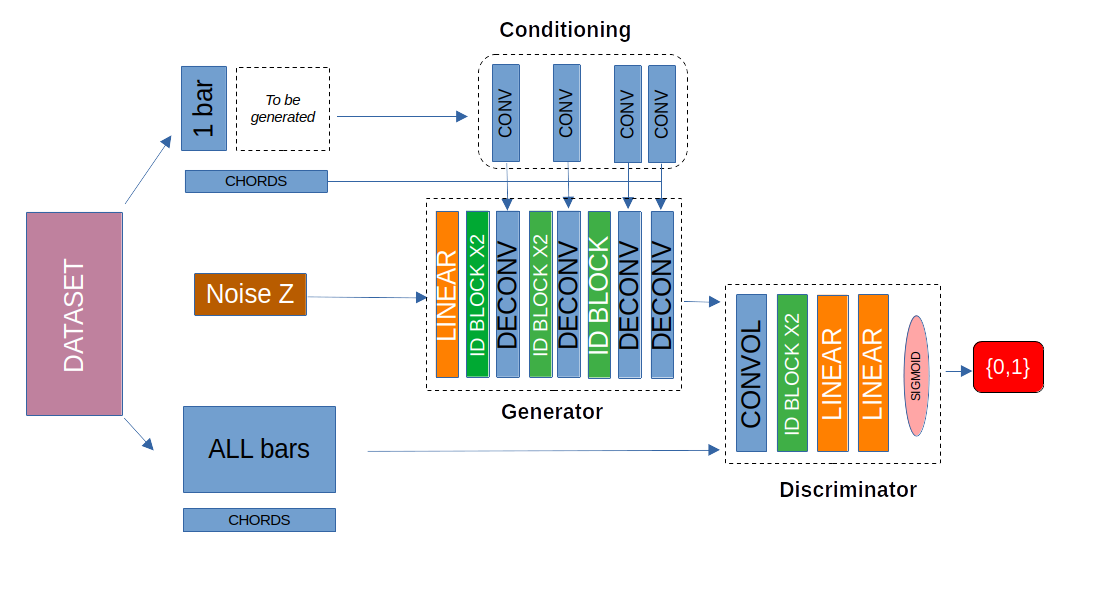

Preprocessing Pipeline - Lakh Dataset

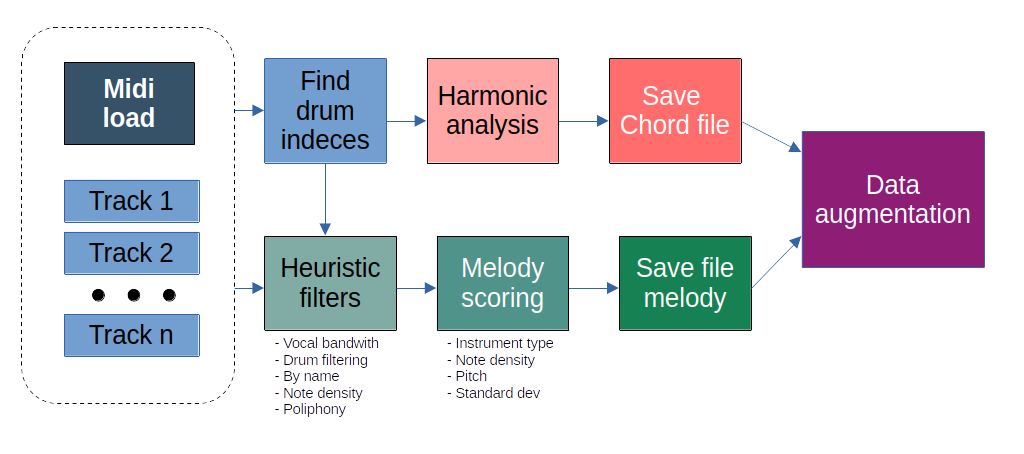


# Preliminars

## Import Libraries

In [ ]:
import numpy as np

import time as time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision.transforms import Compose
from torch.nn.utils import spectral_norm

from collections import Counter, defaultdict
import random
import string

import matplotlib.pyplot as plt

from glob import glob
import re
from tqdm import tqdm
import os

from typing import List, Optional, Dict, Set, Tuple, Any

In [ ]:
# PRETTY MIDI IS THE MAIN TOOL TO PROCESS MIDI
%%capture
!pip install pretty_midi librosa soundfile optuna
import pretty_midi
import optuna

# FOR PLAYING THE GENERATED MIDI
import librosa.display
import soundfile as sf
from IPython.display import Audio

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Download from Drive

In [ ]:
datasetHT = True    # if True, use HookTheory Dataset, else Lakh
download_raw = False # if False, download preprocessed

preprocess = False   # preprocess Lakh dataset
preprocess_ht = False # preprocess Hooktheory dataset

In [ ]:
# In order to preprocess data we need to download it
if preprocess or preprocess_ht:
  download_raw = True

### HOOKTHEORY Dataset - LAKH dataset (already processed)

In [ ]:
%%capture
## MELODY_CHORDS GIA' PROCESSATI
if not download_raw:
  !gdown --folder https://drive.google.com/drive/folders/13YnVlKdhwlVcZr6YyFkUaQYGSeHxpCPA?usp=drive_link
  !tar -xvzf ./preprocessed/melody_chords.tar.gz    # clean_midi
  !tar -xvzf ./preprocessed/melody_chords_ht.tar.gz  # hooktheory


### HOOKTHEORY Dataset - LAKH Dataset (to be processed)

In [ ]:
%%capture
if download_raw:
  !gdown --folder https://drive.google.com/drive/folders/1rxAes3Quw0gpfAERu-ejZ2P6DtFjsF7Q?usp=sharing
  if preprocess:
    !tar -xvzf ./raw/clean_midi.tar.gz
  if preprocess_ht:
    !tar -xvzf ./raw/hooktheory.tar.gz

# Preprocessing pipeline - LAKH Dataset


### Utilities

In [ ]:
def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''
    Converte un piano_roll in un oggetto PrettyMIDI.
    '''
    notes, frames = piano_roll.shape
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # Aggiunge padding per rilevare le note alla fine
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            # Esegue il clipping della velocity nel range valido [1, 127]
            note_velocity = np.clip(int(prev_velocities[note]), 1, 127)

            pm_note = pretty_midi.Note(
                velocity=note_velocity,
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0

    midi.instruments.append(instrument)
    return midi

#-------------------------------------------------------------------------------

def monophonize_track(track: pretty_midi.Instrument, fs: int = 100) -> pretty_midi.Instrument:
    """
    Converte una traccia potenzialmente polifonica in una monofonica,
    mantenendo solo la nota più acuta (highest pitch) per ogni step temporale.
    """
    if not track.notes:
        return track # Ritorna la traccia vuota se non ci sono note

    piano_roll = track.get_piano_roll(fs=fs)

    monophonic_roll = np.zeros_like(piano_roll)
    for t in range(piano_roll.shape[1]):
        notes_at_t = np.where(piano_roll[:, t] > 0)[0]
        if notes_at_t.size > 0:
            highest_note_pitch = np.max(notes_at_t)
            monophonic_roll[highest_note_pitch, t] = piano_roll[highest_note_pitch, t]

    mono_midi = piano_roll_to_pretty_midi(monophonic_roll, fs=fs, program=track.program)

    if mono_midi.instruments:
        mono_track = mono_midi.instruments[0]
        mono_track.name = track.name
        return mono_track
    else:
        return pretty_midi.Instrument(program=track.program, name=track.name)

#-------------------------------------------------------------------------------

def filter_short_notes(track: pretty_midi.Instrument, bpm: float) -> pretty_midi.Instrument:
    """
    Filtra le note più corte di un sedicesimo dalla traccia.
    La durata del sedicesimo è calcolata in base al tempo (BPM) del brano.
    (ridurre rumore tracce rese monofoniche da polifoniche)
    """
    if not track.notes or bpm == 0:
        return track

    # Durata di un beat (semiminima o 1/4) in secondi = 60 / BPM
    # Durata di un sedicesimo = (60 / BPM) / 4 = 15 / BPM
    min_duration = 15.0 / bpm

    # Crea una nuova traccia con solo le note che superano la durata minima
    cleaned_instrument = pretty_midi.Instrument(program=track.program, name=track.name)
    for note in track.notes:
        if (note.end - note.start) >= min_duration:
            cleaned_instrument.notes.append(note)

    return cleaned_instrument

def mid2pianoroll(mid, ticks_per_bar = 16):
    ## traccia singola
    fs = ticks_per_bar / (60/mid.get_tempo_changes()[1][0] * 4) # 4: beats_per bar
    pr = mid.get_piano_roll(fs=fs)
    pr[pr>0]=1
    return pr

### Filter functions

In [ ]:
def filter_percussive_tracks(
    tracks: List[pretty_midi.Instrument],
    percussive_programs: Set[int]
) -> Set[int]:
    """
    Identifica gli indici delle tracce percussive in una lista di tracce MIDI.

    L'identificazione si basa su due criteri principali:
    1. Metadati espliciti (flag `is_drum` o programma MIDI percussivo).
    2. Un'analisi euristica che valuta la varietà dei pitch e la durata media delle note.
       Le tracce percussive tendono ad avere bassa varietà di pitch e note di breve durata.

    Args:
        tracks: Una lista di oggetti `pretty_midi.Instrument`.
        percussive_programs: Un set di numeri di programma MIDI da considerare percussivi.

    Returns:
        Un set contenente gli indici delle tracce identificate come percussive.
    """
    percussive_indices: Set[int] = set()

    for i, track in enumerate(tracks):
        # Criterio 1: Metadati
        if track.is_drum or track.program in percussive_programs:
            percussive_indices.add(i)
            continue

        # Esclusione di tracce con poche note per un'analisi statistica irrilevante
        if len(track.notes) < 10:
            continue

        # Criterio 2: Analisi euristica
        unique_pitches = len(set(note.pitch for note in track.notes))
        # Lo score diminuisce all'aumentare della varietà dei pitch. Normalizzato su un'ottava (12 semitoni).
        score_pitch_variety = max(0, 1.0 - (unique_pitches - 1) / 12.0)

        avg_duration = np.mean([note.end - note.start for note in track.notes])
        # Lo score diminuisce all'aumentare della durata media delle note.
        score_note_duration = 1 / (1 + avg_duration * 10)

        # Combinazione pesata degli score con una soglia di attivazione.
        # I parametri (pesi 0.6/0.4, soglia 0.7) sono euristici.
        if (score_pitch_variety * 0.6 + score_note_duration * 0.4) > 0.7:
            percussive_indices.add(i)

    return percussive_indices

#-------------------------------------------------------------------------------

def filter_track_by_name(track: pretty_midi.Instrument, exclusion_keywords: List[str]) -> bool:
    """
    Filtra le tracce il cui nome contiene parole chiave da escludere (es. 'bass', 'piano').
    Ritorna True se la traccia supera il filtro (non contiene keyword), altrimenti False.
    """
    if not track.name:
        return True # Mantiene la traccia se non ha nome

    track_name_lower = track.name.lower()
    for keyword in exclusion_keywords:
        if keyword in track_name_lower:
            return False # Esclude la traccia se trova una keyword

    return True

#-------------------------------------------------------------------------------

def filter_track_by_pitch(track: pretty_midi.Instrument, min_pitch_threshold: int = 40) -> bool:
    """
    Filtra le tracce che contengono note al di sotto di una soglia di pitch minima.
    Ritorna True se la traccia supera il filtro (tutte le note sono sopra la soglia), altrimenti False.
    - min_pitch_threshold (default=40): Corrisponde a E2 -> nota più bassa di un uomo con voce da basso
    """
    if not track.notes:
        return False  # Scarta tracce vuote

    # Trova la nota più bassa nella traccia
    lowest_pitch = min(note.pitch for note in track.notes)

    # Ritorna True solo se la nota più bassa è uguale o superiore alla soglia
    return lowest_pitch >= min_pitch_threshold

#-------------------------------------------------------------------------------

def filter_track_by_note_density(track: pretty_midi.Instrument, total_duration: float, min_density: float = 0.35) -> bool:
    """
    Filtra le tracce che hanno una bassa densità di note rispetto alla durata totale.
    Ritorna True se la densità di note è superiore alla soglia, altrimenti False.
    - min_density (default=0.35): La traccia deve avere note attive per almeno il 35% del tempo.
    """
    if not track.notes or total_duration == 0:
        return False
    note_time = sum(note.end - note.start for note in track.notes)
    density = note_time / total_duration
    return density >= min_density

#-------------------------------------------------------------------------------

def filter_track_by_polyphony(track: pretty_midi.Instrument, fs: int = 100, polyphony_threshold: float = 0.15) -> bool:
    """
    Filtra le tracce con un'alta percentuale di polifonia. 3 TRACCE CONTEMPORANEAMENTE, 2 VA BENE
    Ritorna True se la traccia è prevalentemente monofonica, altrimenti False.
    - polyphony_threshold (default=0.15): Soglia massima di passi temporali polifonici.
    """
    if len(track.notes) < 2:
        return True
    pianoroll = track.get_piano_roll(fs=fs)
    polyphonic_steps = np.sum(np.sum(pianoroll > 0, axis=0) > 2) # SE METTO >1 DIVENTA ANCHE PER 2 TRACCE
    total_steps = pianoroll.shape[1]
    if total_steps == 0:
        return True
    polyphony_ratio = polyphonic_steps / total_steps
    return polyphony_ratio <= polyphony_threshold

#-------------------------------------------------------------------------------

def find_vocal_by_keywords(midi_data: pretty_midi.PrettyMIDI, keywords: List[str]) -> Optional[pretty_midi.Instrument]:
    """
    Cerca una traccia tramite keyword nel nome. Ha la precedenza su tutti i filtri.
    """
    for i, track in enumerate(midi_data.instruments):
        if not track.name: continue
        track_name_lower = track.name.lower()
        for keyword in keywords:
            if re.search(r'\\b' + re.escape(keyword.lower()) + r'\\b', track_name_lower):
                print(f"Override per nome: Trovata traccia '{track.name}' con keyword '{keyword}'.")
                return track
    return None


### Scoring melody function

In [ ]:
def score_instrument_type(track: pretty_midi.Instrument) -> float:
    #https://soundprogramming.net/file-formats/general-midi-instrument-list/
    melodic_programs = list(range(0, 8)) + list(range(24, 32))  + \
                       list(range(52, 69))
    main_programs = list(range(40, 44)) + list(range(80, 88)) + list(range(72, 80))
    bass_programs = list(range(32, 40))
    pad_programs = list(range(88, 96))
    if track.is_drum: return 0.0
    if track.program in bass_programs: return 0.1
    if track.program in pad_programs: return 0.3
    if track.program in melodic_programs: return 0.8
    if track.program in main_programs: return 1
    return 0.5

#-------------------------------------------------------------------------------

def score_note_density_heuristic(track: pretty_midi.Instrument) -> float:
    if not track.notes: return 0.0
    duration = track.get_end_time()
    if duration == 0: return 0.0
    return 1 - np.exp(-0.25 * (len(track.notes) / duration))

#-------------------------------------------------------------------------------

def score_mean_pitch(track: pretty_midi.Instrument) -> float:
    if not track.notes: return 0.0
    return np.mean([note.pitch for note in track.notes]) / 127.0

#-------------------------------------------------------------------------------

def score_pitch_std(track: pretty_midi.Instrument) -> float:
    if len(track.notes) < 2: return 0.0
    return np.clip(np.std([note.pitch for note in track.notes]) / 20.0, 0, 1.0)


### Chord extraction

In [ ]:
def get_best_match(chroma_vector: np.ndarray, similarity_threshold: float) -> str:
    """
    Trova il miglior accordo per un dato vettore croma utilizzando i template globali.

    Args:
        chroma_vector: Vettore croma da analizzare.
        similarity_threshold: Soglia di similarità coseno per un match valido.

    Returns:
        Il nome dell'accordo (es. "C_maj") o "N.C." (No Chord).
    """
    if np.sum(chroma_vector) < 1e-6:
        return "N.C."

    best_match = {"score": -1.0, "name": "N.C."}

    for root_pc in range(12):
        for quality, template in CHORD_TEMPLATES.items():
            # Ruota il template di accordo per la tonica corrente
            rotated_template = np.roll(template, root_pc)

            # Calcola la similarità coseno
            dot_product = np.dot(chroma_vector, rotated_template)
            norm_product = np.linalg.norm(chroma_vector) * np.linalg.norm(rotated_template)

            if norm_product < 1e-6:
                continue

            similarity = dot_product / norm_product

            if similarity > best_match["score"]:
                best_match["score"] = similarity
                best_match["name"] = f"{PITCH_CLASSES[root_pc]}_{quality}"

    return best_match["name"] if best_match["score"] >= similarity_threshold else "N.C."

#-------------------------------------------------------------------------------

def analyze_harmonic_progression(
    midi_data: pretty_midi.PrettyMIDI,
    percussive_indices: Set[int],
    tracks_to_exclude: Optional[Set[int]] = None,
    similarity_threshold: float = 0.5
) -> List[str]:
    """
    Esegue una pipeline di analisi armonica su un oggetto pretty_midi.

    Args:
        midi_data: L'oggetto `pretty_midi.PrettyMIDI` da analizzare.
        percussive_indices: Un set di indici di tracce percussive, calcolato esternamente.
        tracks_to_exclude: Un set opzionale di indici di tracce da escludere a priori
                           dall'analisi (es. la melodia principale).
        similarity_threshold: La soglia di similarità (0-1) per il riconoscimento degli accordi.

    Returns:
        Una lista di stringhe che rappresenta la progressione armonica, un accordo per
        ogni downbeat (primo beat di ogni misura).
    """
    # --- Fase 1: Filtro delle Tracce ---
    # Unisce gli indici delle tracce percussive (pre-calcolati) con quelli specificati dall'utente.
    all_excluded_indices = percussive_indices.union(tracks_to_exclude if tracks_to_exclude else set())

    # --- Fase 2: Creazione del MIDI Armonico ---
    # Costruisce un nuovo oggetto MIDI contenente solo le tracce armoniche.
    harmonic_midi = pretty_midi.PrettyMIDI()
    for i, track in enumerate(midi_data.instruments):
        if i not in all_excluded_indices:
            harmonic_midi.instruments.append(track)

    if not harmonic_midi.instruments:
        return ["Nessuna traccia armonica rilevata."]

    # --- Fase 3: Calcolo del Cromagramma ---
    piano_roll = mid2pianoroll(harmonic_midi)
    # get chroma as in the pretty midi library
    chroma_matrix = np.zeros((12, piano_roll.shape[1]))
    for note in range(12):
        chroma_matrix[note, :] = np.sum(piano_roll[note::12], axis=0)

    bar_len = 16
    num_bars = int(piano_roll.shape[1] / bar_len)

    progression: List[str] = []
    for i in range(0, num_bars):
      mean_chroma = np.mean(chroma_matrix[:, i*bar_len:(i+1)*bar_len], axis=1)
      chord = get_best_match(mean_chroma, similarity_threshold)
      progression.append(chord)

    return progression

### Melody extraction

In [ ]:
def get_candidate_melody_indices(
    midi_data: pretty_midi.PrettyMIDI,
    drum_track_indices: Set[int],
    verbose: bool = True
) -> List[int]:
    """
    Identifica e ritorna gli indici delle tracce candidate a essere la melodia.

    La funzione esegue una ricerca prioritaria per nome e, in assenza di risultati,
    procede con una pipeline di filtraggio escludendo le tracce non idonee.
    L'output è una lista di indici pronti per la successiva fase di scoring.

    Args:
        midi_data (pretty_midi.PrettyMIDI): L'oggetto MIDI da analizzare.
        drum_track_indices (Set[int]): Un set di indici di tracce percussive pre-calcolati.
        verbose (bool): Se True, stampa log dettagliati del processo di filtraggio.

    Returns:
        List[int]: Una lista contenente gli indici delle tracce candidate.
    """
    # --- Configurazione dei parametri per il filtraggio ---
    params = {
        'min_notes_for_analysis': 20, 'polyphony_fs': 100,
        'polyphony_threshold': 0.30, 'note_density_threshold': 0.30,
        'min_pitch': 40,  # E2
        'melody_keywords': ['melody', 'melodia', 'lead', 'vocal', 'vocals', 'voice',
                            'singer', 'cantante', 'main', 'solo', 'trumpet', 'sax', 'choir'],
        'exclusion_keywords': ['bass', 'pad', 'rhodes']
    }

    # --- FILTRAGGIO DELLE TRACCE ---
    candidate_indices: List[int] = []
    total_duration = midi_data.get_end_time()

    if total_duration == 0:
        if verbose: print("Durata del brano è zero. Impossibile procedere.")
        return []

    for i, track in enumerate(midi_data.instruments):
        # La logica di filtraggio determina se l'indice della traccia deve essere aggiunto ai candidati.
        log_message = ""
        is_candidate = True

        if len(track.notes) < params['min_notes_for_analysis']:
            is_candidate = False
            log_message = f"SCARTATA: Poche note ({len(track.notes)})."
        elif i in drum_track_indices:
            is_candidate = False
            log_message = "SCARTATA: Indice percussivo pre-calcolato."
        elif not filter_track_by_name(track, params['exclusion_keywords']):
            is_candidate = False
            log_message = "SCARTATA: Nome traccia escluso."
        elif not filter_track_by_pitch(track, params['min_pitch']):
            is_candidate = False
            log_message = "SCARTATA: Pitch medio troppo basso."
        elif not filter_track_by_note_density(track, total_duration, params['note_density_threshold']):
            is_candidate = False
            log_message = "SCARTATA: Densità note bassa."
        elif not filter_track_by_polyphony(track, params['polyphony_fs'], params['polyphony_threshold']):
            is_candidate = False
            log_message = "SCARTATA: Troppo polifonica."

        if is_candidate:
            candidate_indices.append(i)
            log_message = "CANDIDATA"

        if verbose:
            print(f"Traccia {i} ('{track.name}'): {log_message}")

    if verbose:
        print("-" * 50)
        print(f"Trovati {len(candidate_indices)} indici candidati dopo il filtraggio.")

    return candidate_indices

#-------------------------------------------------------------------------------

def get_best_candidate(midi_data, candidate_melody_indices, weights=None, verbose=False):
    '''monophonize, filter, SCORING E SELEZIONE FINALE'''
    if not weights:
        weights = {
            'instrument_type': 0.3,
            'note_density': 0.4,
            'mean_pitch': 0.15,
            'pitch_std': 0.15
        }

    if not candidate_melody_indices:
        if verbose: print("\nNessuna traccia candidata trovata. Impossibile estrarre la melodia.")
        return None, []

    best_score = -10
    best_track = None

    for index in candidate_melody_indices:
        track = midi_data.instruments[index]
        monophonic_track = monophonize_track(track)
        cleaned_track = filter_short_notes(monophonic_track, midi_data.estimate_tempo())
        scores = {
            'instrument_type': score_instrument_type(track),
            'note_density': score_note_density_heuristic(track),
            'mean_pitch': score_mean_pitch(track),
            'pitch_std': score_pitch_std(track)
        }
        final_score = sum(scores[key] * weights.get(key, 0) for key in scores)
        if final_score > best_score:
            best_score = final_score
            best_track = cleaned_track

    return best_track


In [ ]:
def ensure_same_duration(midi_obj):
    max_time = max(note.end for track in midi_obj.instruments for note in track.notes)
    for track in midi_obj.instruments:
        if not track.notes:
            continue
        last_note_end = max(note.end for note in track.notes)
        if last_note_end < max_time:
            # Estendi la durata dell'ultima nota se possibile
            last_note = max(track.notes, key=lambda n: n.end)
            last_note.end = max_time
    return midi_obj


In [ ]:
# Definizioni dei Template e Costanti
CHORD_TEMPLATES: Dict[str, np.ndarray] = {
    'maj': np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
    'min': np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]),
    #'dom7': np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0]),
    #'pwr': np.array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
}

PITCH_CLASSES: List[str] = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'] # 12 note fondamentali

PERCUSSIVE_PROGRAMS: Set[int] = {47, 113, 114, 115, 116, 117, 118, 119} # tipicamente usati per traccie ritmiche

### Preprocessing main

In [ ]:
# PREPROCESS LAKH - CLEAN_MIDI
if preprocess:
  input_directory = '/content/clean_midi'
  output_directory = '/content/Melody_Chords'
  # CICLO SU TUTTI I BRANI
  midi_path = glob(f"{input_directory}/**/*.mid", recursive=True)
  maxfile = 128 # <-- scegliere quanti file prendersi in totale sono più di 15000

  if not os.path.exists(output_directory):
    os.makedirs(output_directory)
  for midi_input_path in tqdm(midi_path[:maxfile], desc="Processing midi files..."):

      try:
        # 1. CARICAMENTO MIDI
        midi_obj = pretty_midi.PrettyMIDI(midi_input_path)
        base_filename = os.path.basename(midi_input_path)

        # Trovo indici drum
        drum_index = filter_percussive_tracks(midi_obj.instruments, PERCUSSIVE_PROGRAMS)

        # Garantire la stessa lunghezza per tutte le tracks
        midi_obj = ensure_same_duration(midi_obj)


        # 2. ANALISI ARMONICA
        harmonic_progression = analyze_harmonic_progression(midi_obj, drum_index)

        if harmonic_progression:
            harmony_output_path = os.path.join(output_directory, base_filename.replace('.mid','.txt'))
            with open(harmony_output_path, 'w', encoding='utf-8') as f:
                f.write("\n".join(harmonic_progression))
            print(f"Analisi armonica salvata in: '{harmony_output_path}'")
        else:
            print("Nessuna progressione armonica è stata rilevata.")

        # 3. ESTRAZIONE MELODIA
        vocal_line = find_vocal_by_keywords(midi_obj, ['vocal', 'vocals', 'voice', 'melody', 'choir'])
        if vocal_line:
            melody_track = monophonize_track(vocal_line)
            melody_track = filter_short_notes(melody_track, midi_obj.estimate_tempo())
        else:
            candidate_melody_indices = get_candidate_melody_indices(midi_obj, drum_index, verbose=False)
            # Monophonize, filter, SCORING
            melody_track = get_best_candidate(midi_obj, candidate_melody_indices)

        # 4. SALVATAGGIO MELODIA (con pipeline di pulizia)
        if melody_track:
            # Salvataggio della traccia finale pulita
            final_midi = pretty_midi.PrettyMIDI()
            final_midi.instruments.append(melody_track)
            melody_output_path = os.path.join(output_directory, base_filename)
            final_midi.write(melody_output_path)
            print(f"Melodia pulita salvata in: '{melody_output_path}'")
        else:
            print("Nessuna traccia melodia trovata per questo file.")
      except:
        print(f"Errore")


### Import chords from files (like: C#, ....) - Lakh dataset


In [ ]:
def encode_progression(progression: List[str]) -> np.ndarray:
    """
    Converte una progressione di accordi in una rappresentazione numerica.

    Args:
        progression: Una lista di stringhe di accordi (es. ['C_maj', 'A_min']).

    Returns:
        Un array NumPy di forma (13, N), dove N è il numero di accordi.
        Le righe 0-11 rappresentano la nota fondamentale (one-hot).
        La riga 12 rappresenta la qualità (1: maggiore, 0: minore).
    """
    # Definizioni delle mappature
    PITCH_CLASSES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    QUALITY_MAP = {'maj': 1.0, 'min': 0.0}

    encoded_columns = []

    for chord_str in progression:
        # Inizializza un vettore colonna di zeri per l'accordo corrente
        column_vector = np.zeros(13, dtype=float)

        # Gestisce il caso di "Nessun Accordo" (N.C.)
        if chord_str == "N.C.":
            encoded_columns.append(column_vector)
            continue

        try:
            # Separa la nota dalla qualità
            note_name, quality_name = chord_str.split('_')

            # 1. Codifica della nota fondamentale (one-hot)
            if note_name in PITCH_CLASSES:
                note_index = PITCH_CLASSES.index(note_name)
                column_vector[note_index] = 1.0

            # 2. Codifica della qualità (maggiore/minore)
            if quality_name in QUALITY_MAP:
                column_vector[12] = QUALITY_MAP[quality_name]

        except ValueError:
            # Gestisce stringhe malformate che non contengono '_'
            print(f"Avviso: L'accordo '{chord_str}' ha un formato non valido e sarà codificato come una colonna di zeri.")

        encoded_columns.append(column_vector)

    # Impila orizzontalmente i vettori colonna per formare la matrice finale
    return np.stack(encoded_columns, axis=1)

#-------------------------------------------------------------------------------

def encode_progression_from_file(file_path: str) -> np.ndarray:
    """
    Legge una progressione di accordi da un file di testo e la converte
    nella rappresentazione numerica.

    Args:
        file_path: Il percorso del file di testo. Il file deve contenere
                   un accordo per riga.

    Returns:
        Un array NumPy di forma (13, N) risultante dalla codifica.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # Legge le righe, rimuove spazi bianchi e newline,
            # e ignora le righe vuote.
            lines = [line.strip() for line in f.readlines() if line.strip()]

        if not lines:
            print("Avviso: il file è vuoto o non contiene accordi validi.")
            return np.empty((13, 0))

        # Utilizza la funzione di codifica esistente
        return encode_progression(lines)

    except FileNotFoundError:
        print(f"ERRORE: Il file specificato non è stato trovato al percorso '{file_path}'")
        return np.empty((13, 0)) # Restituisce una matrice vuota in caso di errore
    except Exception as e:
        print(f"ERRORE IMPREVISTO durante la lettura del file: {e}")
        return np.empty((13, 0))



# Preprocessing pipeline - Hooktheory


In [ ]:
CHORD_TEMPLATES_ht = [np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]), #minore
                   np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]), #maggiore
                   ]

def get_harmony(mid, nbar, similarity_threshold = .7):
    piano_roll = mid2pianoroll(mid)
    # get chroma as in the pretty midi library
    chroma_matrix = np.zeros((12, piano_roll.shape[1]))
    for note in range(12):
        chroma_matrix[note, :] = np.sum(piano_roll[note::12], axis=0)

    bar_len = 16
    # num_bars = int(np.floor(piano_roll.shape[1] / bar_len))
    chords = []
    for i in range(0, nbar):
        mean_chroma = np.mean(chroma_matrix[:, i*bar_len:(i+1)*bar_len], axis=1)
        chord = get_best_match_ht(mean_chroma, similarity_threshold)
        chords.append(chord)
    return chords

#-------------------------------------------------------------------------------

def get_best_match_ht(chroma_vector: np.ndarray, similarity_threshold: float):
    best_match = [0,0]
    best_match_score = -1.0
    if np.sum(chroma_vector) < 1e-6:
        return best_match

    chroma_norm = np.linalg.norm(chroma_vector)
    for i, template in enumerate(CHORD_TEMPLATES_ht):
        norm_product = chroma_norm*np.linalg.norm(template)
        for root_pc in range(12):
            # Ruota il template di accordo per la tonica corrente
            rotated_template = np.roll(template, root_pc)
            # Calcola la similarità coseno
            dot_product = np.dot(chroma_vector, rotated_template)
            similarity = dot_product / norm_product

            if similarity > best_match_score:
                best_match_score = similarity
                best_match = [root_pc, i]

    return best_match if best_match_score >= similarity_threshold else [0,0]

#-------------------------------------------------------------------------------
# formato diverso di harmony file - più facile da leggere e scrivere ma meno interpretabile

def write_harmony_file(chords, output_path):
    with open(output_path, 'w') as f:
        for chord in chords:
            key, quality = chord
            f.write(f'{key} {quality}\n')
    return

#-------------------------------------------------------------------------------

def read_harmony_file(input_path):
    with open(input_path, 'r') as f:
        lines = f.readlines()
    T = len(lines)
    chords = np.zeros((13, T))
    for i,line in enumerate(lines):
        key_str, minor_str = line.strip().split()
        key = int(key_str)
        is_minor = int(minor_str)
        chords[key,i] = 1
        chords[12,i] = is_minor
    return chords


In [ ]:
# DAL SITO hookthoery/theorytabs
# i midi scaricati hanno la melodia nella prima traccia e gli accordi nella seconda
# - estrarre prima traccia e salvarla altrove
# - estrarre seconda, fare il piano roll, fare il chroma medio per battuta e trovare l'accordo corrispondente
# - salvarlo in formato utile: es 7 1 \n 12 0 \n ...
# - funzione per leggere questo formato e caricarlo in one hot representation 13 x 1 vettore per battuta
if preprocess_ht:
  base_path = '/content'

  hookthoery_folder = 'hooktheory'
  output_folder = 'melody_chord_ht'

  hookthoery_folder_path = os.path.join(base_path, hookthoery_folder)
  output_folder_path = os.path.join(base_path, output_folder)

  if not os.path.exists(output_folder_path):
      os.makedirs(output_folder_path)

  midi_files = glob(f'{hookthoery_folder_path}/*.mid')

  for midi_file in midi_files:
      print(f"Doing {midi_file}")
      output_midi_file = midi_file.replace(hookthoery_folder, output_folder)
      output_chord_file = output_midi_file.replace('.mid', '.txt')

      midi = pretty_midi.PrettyMIDI(midi_file)
      try:

          melody_midi = pretty_midi.PrettyMIDI()
          melody_midi.instruments.append(midi.instruments[0])

          harmony_midi = pretty_midi.PrettyMIDI()
          harmony_midi.instruments.append(midi.instruments[1])

      except Exception as e:
          print(f"Error with {midi_file}: {e}")

      melody_midi.write(output_midi_file)

      nbar =  int(np.floor( mid2pianoroll(melody_midi).shape[1] / 16))
      chords = get_harmony(harmony_midi, nbar)
      # salva su file
      write_harmony_file(chords, output_chord_file)
      # per leggerli
      # read_chord = read_harmony_file(output_chord_file)

# Dataset class

In [ ]:
class MidiDataset(Dataset):

    def __init__(self, file_path, transform=None, n_bars=4, dataset_HT = False, maxfile=10000):
        """
           Midi path
        """
        self.transform = transform
        self.data = []
        midi_paths = list(glob(f"{file_path}/*.mid"))[:maxfile]
        print(f"Loading {len(midi_paths)} MIDI files...")

        for file_path in tqdm(midi_paths, desc= "Parsing MIDI files"):
            mid = pretty_midi.PrettyMIDI(file_path)
            pr = torch.from_numpy(mid2pianoroll(mid)).float()

            #accordi
            if dataset_HT:
              chords = torch.from_numpy(read_harmony_file(file_path.replace(".mid", ".txt")))
            else:
              chords = torch.from_numpy(encode_progression_from_file(file_path.replace(".mid", ".txt")))

            len_track = pr.shape[1]
            bar_size = 16 * n_bars
            tot_bars = len_track / bar_size

            for i in range(int(tot_bars)):
                bar = pr[:, i*bar_size:(i+1)*bar_size]
                bar = bar.unsqueeze(0)

                chords_bar = chords[:, i*n_bars:(i+1)*n_bars].float()
                if chords_bar.shape[1]<n_bars:
                  chords_bar = torch.hstack([chords_bar, torch.zeros(13,n_bars-chords_bar.shape[1])]) #zero padding quando più corto
                if bar[...,0:16].sum()>0:
                  self.data.append((bar,chords_bar))

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample


## Data augmentation

In [ ]:
class RandomPitchShift:
    '''
    shift the whole piano roll and the chord by a random number of semitones
    '''
    def __init__(self, min_shift=-6, max_shift=6):
        self.min_shift = min_shift
        self.max_shift = max_shift

    def __call__(self, sample):
        image, chord = sample

        shift = torch.randint(self.min_shift, self.max_shift + 1, (1,)).item()

        if shift == 0:
            return sample
        # Perform roll + zero out the clipped region on the image
        shifted_img = torch.roll(image, shifts=shift, dims=1)
        if shift > 0:
            shifted_img[:, :shift, :] = 0  # Zero out bottom notes that "fell off"
        else:
            shifted_img[:, shift:, :] = 0 # Zero out top notes that "wrapped around"

        # roll on chord
        shifted_chords = torch.zeros_like(chord)
        shifted_chords[:12,:] = torch.roll(chord[:12,:], shifts=shift, dims=0)
        shifted_chords[12,:] = chord[12,:]

        return (shifted_img, shifted_chords)


In [ ]:
class RandomNoteDropout:
    """
    rimuovere note esistenti nel pianoroll con probabilità dropout_prob
    """
    def __init__(self, dropout_prob=0.05):

        self.dropout_prob = dropout_prob

    def __call__(self, image):

        augmented_image = image[0].clone()
        note_mask = augmented_image > 0 # nota esistente
        random_mask = torch.rand_like(augmented_image, dtype=torch.float32) < self.dropout_prob
        dropout_locations = note_mask & random_mask # nota esistente e probabilità buona
        augmented_image[dropout_locations] = 0.0

        return (augmented_image, image[1])

In [ ]:
class RandomNoteShift:
    '''
    muove note esistenti nel pianoroll con probabilità noise_prob di un numero di toni random tra -max_tone_shift e max_tone_shift.
    max_tone_shift = 1 indica 2 semitoni
    '''
    def __init__(self, noise_prob=0.1, max_tone_shift=1):
        self.noise_prob = noise_prob
        self.max_tone_shift = max_tone_shift

    def __call__(self, sample):

        image, chord = sample
        _, H,T = image.shape# image: (1, H, T)

        new_image = torch.zeros_like(image)

        # Extract active pitch per time step (argmax over pitch axis)
        active_pitches = torch.argmax(image[0], dim=0)  # shape: (T,)

        # Determine which time steps contain a note
        has_note = image[0].sum(dim=0) > 0  # shape: (T,)

        # Decide which notes to shift
        shift_flags = torch.rand(T) < self.noise_prob  # shape: (T,)
        offsets = 2 * torch.randint(
            -self.max_tone_shift, self.max_tone_shift + 1, (T,)
        )  # random integers in [-max, max]

        # Apply shifts only where shift_flag is True
        new_pitches = active_pitches + (shift_flags.int() * offsets)
        new_pitches = torch.clamp(new_pitches, 0, H - 1)

        # Apply only where there was a note originally
        cols = torch.arange(T)[has_note]       # time indices
        rows = new_pitches[has_note]           # new pitch indices

        new_image[0, rows, cols] = 1.0             # set note on
        return (new_image, chord)


In [ ]:
def get_dataloader(dataset, BATCH_SIZE=32):

  train_size = int(0.8 * len(dataset)) # 80% per il training
  val_size = len(dataset) - train_size # Il resto per la validation
  # Train Val split
  train_dataset, val_dataset = random_split(dataset, [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))
  print(f"Dimensioni del dataset di training: {len(train_dataset)}")
  print(f"Dimensioni del dataset di validation: {len(val_dataset)}")

  # Dataloader
  train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
  return train_loader, val_loader

## Example Sample from Dataset

Loading 549 MIDI files...


Parsing MIDI files: 100%|██████████| 549/549 [00:01<00:00, 482.38it/s]


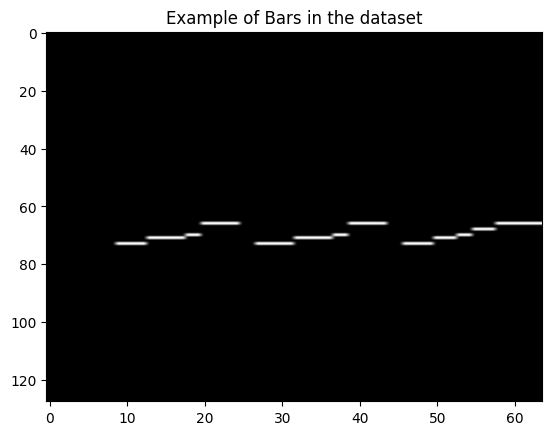

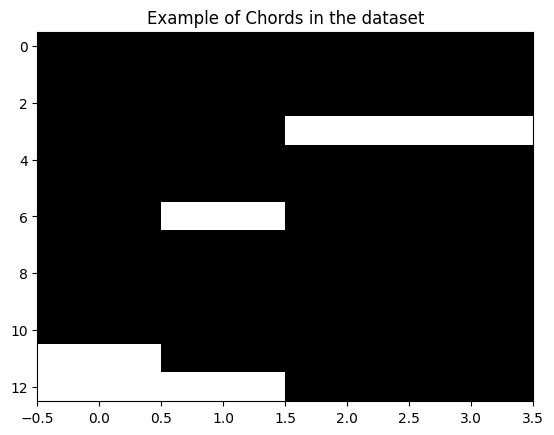

In [ ]:
midi_path = '/content/melody_chord_ht'
nbars = 4
augmentation_pipeline = None
dataset = MidiDataset(midi_path, transform=augmentation_pipeline, n_bars=nbars, dataset_HT = True)
for sample in dataset:
  bar, chord = sample
  plt.title('Example of Bars in the dataset')
  plt.imshow(bar.squeeze(0), cmap='gray', aspect = 'auto')
  plt.show()
  plt.title('Example of Chords in the dataset')
  plt.imshow(chord, cmap='gray', aspect = 'auto')
  plt.show()
  break

# "Human" scoring

Heuristic objective criteria to evaluate the quality of the generated melodies

In [ ]:
def chord_to_vector(chord):
  '''
  chord 13 x 1 -> 12 x 1
  l'ultimo è minore/maggiore
  '''

  if chord[12] == 1:
    # maggiore
    base = np.array([1, 0, 0, 0, 1, 0 ,0, 1, 0, 0, 0, 0])
  else:
    # minore
    base =  np.array([1, 0, 0, 1, 0 ,0, 0, 1, 0, 0, 0, 0])

  vec = np.roll(base, shift=np.argmax(chord[:12]))
  return vec

#===============================================================================
# SCORING FUNCTIONS
#===============================================================================

def calculate_harmony_score(melody, chords):
    ## trasformare battuta della melodia in chorma
     # get chroma as in the pretty midi library
    chroma_matrix = np.zeros((12, melody.shape[1]))
    for note in range(12):
        chroma_matrix[note, :] = np.sum(melody[note::12], axis=0)

    bar_len = 16
    num_bars = int(melody.shape[1] / bar_len)

    similarities = 0
    for i in range(0, num_bars):
      mean_chroma = np.mean(chroma_matrix[:, i*bar_len:(i+1)*bar_len], axis=1)
      # trasformare chords in vettore come sopra : maggiore (1 0 0 0 1 0 0 0 1 ) o minore (1 0 0 1 0 0 0 1) + shift dato dall'uno nelle prime dodici componenti
      chroma_norm = np.linalg.norm(mean_chroma)
      if chroma_norm < 1e-8:
        # battuta vuota -> score 0
        continue
      harmony = chord_to_vector(chords[:,i])
      # calcolare cosine similarity tra le due # prodotto scalare solo con l'accordo di riferimento
      similarities += np.dot(mean_chroma, harmony) / (chroma_norm * np.linalg.norm(harmony))

    ## ritornare media dei quattro -> valore tra -1 e 1  (0 e 1 perché tutti positivi)
    return similarities / num_bars

#-------------------------------------------------------------------------------

def calculate_range_score(melody, pitch_range = (55, 84)) -> float:
    """S_range: Calcola il rispetto del range melodico."""
    melody_1d = np.argmax(melody,axis=0) # vettore 1d con indici di note attive. es: [ 48, 24, 32, ...]
    is_in_range = (melody_1d>pitch_range[0]) & (melody_1d<pitch_range[1])

    return sum(is_in_range)/len(melody_1d)

#-------------------------------------------------------------------------------

def calculate_contour_score(melody, max_jump = 5 ) -> float:
    """S_contour: Penalizza i salti melodici grandi"""
    melody_1d = np.argmax(melody,axis=0)

    # togliere zeri
    melody_1d = melody_1d[melody_1d>0]

    intervals = np.abs(np.diff(melody_1d))
    penalty = np.sum(intervals)

    # Usa un decadimento esponenziale per mappare la penalità a [0, 1]
    k = 0.01
    return np.exp(-k * penalty)

#-------------------------------------------------------------------------------

def calculate_motif_score(melody: list) -> float:
    '''
    S_motif: Stima la coerenza strutturale tramite l'entropia degli intervalli.
    Un'entropia più bassa suggerisce una maggiore struttura e ripetitività.
    '''

    melody_1d = np.argmax(melody,axis=0)

    intervals = np.diff(melody_1d)

    if len(intervals) == 0:
        return 0.0

    # Calcolo dell'entropia di Shannon sulla distribuzione degli intervalli
    counts = Counter(intervals)
    total_intervals = len(intervals)
    probabilities = np.array([count / total_intervals for count in counts.values()])

    entropy = -np.sum(probabilities*np.log2(probabilities))

    # Normalizza l'entropia. L'entropia massima è log2(numero di intervalli unici)
    num_unique_intervals = len(counts)
    if num_unique_intervals <= 1:
        return 0. # stessa nota non è granché

    max_entropy = np.log2(num_unique_intervals)
    normalized_entropy = entropy / max_entropy

    # Lo score è 1 - entropia normalizzata. Più struttura (meno entropia) -> score più alto.
    return 1.0 - normalized_entropy

#-------------------------------------------------------------------------------

def score_melody(melody, chords, weights = None):
    """
    Calcola uno score di qualità per una melodia generata, restituendo i singoli
    componenti e il punteggio finale pesato.
    """
    if weights is None:

      weights = {'harmony': 1,
                    'range': 1,
                    'contour': 1,
                    'motif': 1
                }

    melody = np.where(melody > 0.9, 1, 0)

    scores = {
        'harmony': calculate_harmony_score(melody, chords),
        'range': calculate_range_score(melody),
        'contour': calculate_contour_score(melody),
        'motif': calculate_motif_score(melody)
    }

    total_score = 0.0
    total_weight = sum(weights.values())

    for key, weight in weights.items():
        total_score += scores.get(key, 0) * weight
    total_score /= total_weight

    return  total_score


def score_batch(images, chords):
    '''
    compute the average of the score of each melody in the batch
    '''
    cum_score = 0
    b = images.shape[0]
    images = images.squeeze(1).detach().cpu().numpy()
    chords = chords.detach().cpu().numpy()
    for i in range(b):
      cum_score += score_melody(images[i], chords[i])

    return cum_score/b

## Human score on chosen Dataset




In [ ]:
if datasetHT:
  midi_path = '/content/melody_chord_ht'
  maxfile = 512
else:
  midi_path = '/content/Melody_Chords'
  maxfile = 256

nbars = 4
augmentation_pipeline = None
dataset = MidiDataset(midi_path, transform=augmentation_pipeline, n_bars=nbars, dataset_HT = datasetHT, maxfile=maxfile)

Loading 512 MIDI files...


Parsing MIDI files: 100%|██████████| 512/512 [00:01<00:00, 332.61it/s]


In [ ]:
A = np.zeros((len(dataset),4))
for i, (melody, chord) in enumerate(dataset):
  melody = melody.squeeze(0).numpy()
  A[i, 0] = calculate_harmony_score(melody, chord)
  A[i, 1] = calculate_range_score(melody)
  A[i, 2] = calculate_contour_score(melody)
  A[i,3] = calculate_motif_score(melody)

mean_scores = np.mean(A,axis=0)
print("Human scores in chosen dataset: ", mean_scores)
print(f"Mean human score: {np.mean(mean_scores):.4f} <- to compare with generated melodies")

Human scores in chosen dataset:  [0.49335828 0.72582679 0.70507257 0.54071286]
Mean human score: 0.6162 <- to compare with generated melodies


# GAN

## Utils

In [ ]:
def fit_size(vec: torch.Tensor, shape: tuple, channel=None) -> torch.Tensor:
  '''
  Function to adapt 1D conditioning to the layer input dimension
  '''
  # Unsqueeze until vec has same rank as shape
  shape = list(shape)
  while vec.dim() < len(shape):
      vec = vec.unsqueeze(-1)

  if channel:
    shape[1] = channel
  # Now repeat along dims to cover target shape
  repeat_factor = []
  for i in range(len(shape)):
      repeat_factor.append(int(np.ceil(shape[i] / vec.shape[i])))

  vec = vec.repeat(*repeat_factor)

  # Slice to target shape
  slices = tuple(slice(0, s) for s in shape)
  vec = vec[slices]

  return vec

In [ ]:
def make_bars(images, chords, device, generator, noise_dim, nbars, keep_original = True):
  '''
  Function to create a sequence of bars using a generator.
  '''
  images = images.to(device)
  chords = chords.to(device)

  BATCH_SIZE = images.shape[0]
  start_idx = 0

  bars = []
  old_bar = images[...,0:16] # first bar is genuine
  if nbars == 1:
    keep_original = False

  if keep_original:
    bars.append(old_bar)
    start_idx = 1

  for i in range(start_idx, nbars):
    z = torch.randn(BATCH_SIZE, noise_dim, device=device)
    chord = chords[:,i].unsqueeze(1)
    new_bar = generator(z,prev = old_bar, chord = chord)
    old_bar = new_bar
    bars.append(new_bar)

  G_out = torch.cat(bars, dim=-1)
  return G_out

In [ ]:
def weights_init(m):
  '''
  Iniiialize the weights of the model
  '''
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      #nn.init.normal_(m.weight.data, 0.0, .1)
      nn.init.xavier_uniform_(m.weight.data)
  if classname.find('Linear') != -1:
      #nn.init.normal_(m.weight.data, 0.0, .1)
      nn.init.xavier_uniform_(m.weight.data)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, .1)
      nn.init.constant_(m.bias.data, 0)

## ResNet building blocks

In [ ]:
class MainPath(nn.Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = nn.Sequential(
            nn.Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            nn.BatchNorm2d(F1),
            nn.ReLU(),
            nn.Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(F2),
            nn.ReLU(),
            nn.Conv2d(F2, F3, kernel_size=1),
            nn.BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

#-------------------------------------------------------------------------------

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y


#-------------------------------------------------------------------------------

class SimpleIdentityBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(x + self.block(x))

## GENERATOR

In [ ]:
class Generator(nn.Module):
  def __init__(self, hidden_size, cond1d=True, cond2d=True):
    super().__init__()
    self.hidden_size = hidden_size
    self.tau = 1

    self.cond1d = cond1d
    self.cond2d = cond2d

    dimgen1 = 256
    dimgen2 = 128
    dimgen3 = 64
    dimgen4 = 32

    if self.cond1d:
      dimgen1 +=128
      dimgen2 +=64
      dimgen3 +=32
      dimgen4 +=16

    if self.cond2d:
      dimgen1 += 256
      dimgen2 += 128
      dimgen3 += 64
      dimgen4 += 32

#-------------------------------------------------------------------------------

    if self.cond2d:

      # CONDITIONER
      self.cond1 = nn.Sequential(  # → [B, 32, 64, 8]
          nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(32),
          nn.Dropout(0.1),
          nn.LeakyReLU(0.2)
      )
      self.cond2 = nn.Sequential(  # → [B, 64, 32, 4]
          nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(64),
          nn.Dropout(0.1),
          nn.LeakyReLU(0.2)
      )
      self.cond3 = nn.Sequential(  # → [B, 128, 16, 2]
          nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.Dropout(0.1),
          nn.LeakyReLU(0.2)
      )
      self.cond4 = nn.Sequential(  # → [B, 256, 8, 1]
          nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
          nn.BatchNorm2d(256),
          nn.Dropout(0.1),
          nn.LeakyReLU(0.2)
      )

#-------------------------------------------------------------------------------

    ## GENERATOR
    self.gen_fc = nn.Sequential(
        nn.Linear(hidden_size, 128 * 16 * 1),
        nn.BatchNorm1d(128 * 16 * 1),
        nn.LeakyReLU()
    )

    self.gen1 = nn.Sequential(  # → [B, 128, 16, 2]
        nn.ConvTranspose2d(dimgen1 , 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)), # 256 original # 256 conditioner # 1d conditioning
        nn.BatchNorm2d(128),
        nn.LeakyReLU()
    )
    self.gen2 = nn.Sequential(  # → [B, 64, 32, 4]
        nn.ConvTranspose2d(dimgen2, 64, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),
        nn.BatchNorm2d(64),
        nn.LeakyReLU()
    )
    self.gen3 = nn.Sequential(  # → [B, 32, 64, 8]
        nn.ConvTranspose2d(dimgen3, 32, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),
        nn.BatchNorm2d(32),
        nn.LeakyReLU()
    )
    self.gen4 = nn.Sequential(  # → [B, 1, 128, 16]
        nn.ConvTranspose2d(dimgen4 , 1, kernel_size=3, stride=2, padding=1, output_padding=(1, 1)),
        #nn.Sigmoid()
    )

    self.resnet1 = nn.Sequential(
            IdentityBlock(dimgen1, [64, 64, dimgen1], 3),
            #IdentityBlock(dimgen1, [64, 64, dimgen1], 3),
            #IdentityBlock(dimgen1, [64, 64, dimgen1], 3)
        )
    self.resnet2 = nn.Sequential(
            IdentityBlock(dimgen2, [32, 32, dimgen2], 3),
            #IdentityBlock(dimgen2, [32, 32, dimgen2], 3),
            #IdentityBlock(dimgen2, [32, 32, dimgen2], 3)
        )
    self.resnet3 = nn.Sequential(
            IdentityBlock(dimgen3, [16, 16, dimgen3], 3),
            #IdentityBlock(dimgen3, [16, 16, dimgen3], 3),
            #IdentityBlock(dimgen3, [16, 16, dimgen3], 3) #era commentato prima
        )


    if self.cond1d and self.cond2d:
      self._active_forward = self._fw2d1d
    elif self.cond1d:
        self._active_forward = self._fw1d
    elif self.cond2d:
        self._active_forward = self._fw2d
    else:
        self._active_forward = self._fwd

#-------------------------------------------------------------------------------

  def _fw2d1d(self, z, prev=None, chord=None):

    if prev is None:
        raise ValueError("previous bar missing")
    # 2d conditioning
    c1 = self.cond1(prev)  # [B, 32, 64, 8]
    c2 = self.cond2(c1)    # [B, 64, 32, 4]
    c3 = self.cond3(c2)    # [B, 128, 16, 2]
    c4 = self.cond4(c3)    # [B, 256, 8, 1]

    y = self.gen_fc(z).view(-1, 256, 8, 1)

    d4 = fit_size(chord, y.shape, channel=128)
    y = torch.cat([y, c4, d4], dim=1)
    y = self.resnet1(y)
    y = self.gen1(y)  # [B, 128, 16, 2]

    d3 = fit_size(chord, y.shape, channel=64)
    y = torch.cat([y, c3, d3], dim=1)
    y = self.resnet2(y)
    y = self.gen2(y)  # [B, 64, 32, 4]

    d2 = fit_size(chord, y.shape, channel=32)
    y = torch.cat([y, c2, d2], dim=1)
    y = self.resnet3(y)
    y = self.gen3(y)  # [B, 32, 64, 8]


    d1 = fit_size(chord, y.shape, channel=16)
    y = torch.cat([y,c1,d1], dim=1)
    y = self.gen4(y)  # [B, 1, 128, 16]
    y = F.softmax(y / self.tau, dim=2)
    return y

  def _fw2d(self, z, prev=None, chord=None):

    if prev is None:
        raise ValueError("previous bar missing")
    # 2d conditioning
    c1 = self.cond1(prev)  # [B, 32, 64, 8]
    c2 = self.cond2(c1)    # [B, 64, 32, 4]
    c3 = self.cond3(c2)    # [B, 128, 16, 2]
    c4 = self.cond4(c3)    # [B, 256, 8, 1]

    y = self.gen_fc(z).view(-1, 256, 8, 1)
    y = torch.cat([y, c4], dim=1)
    y = self.resnet1(y)
    y = self.gen1(y)  # [B, 128, 16, 2]

    y = torch.cat([y, c3], dim=1)
    y = self.resnet2(y)
    y = self.gen2(y)  # [B, 64, 32, 4]

    y = torch.cat([y, c2], dim=1)
    y = self.resnet3(y)
    y = self.gen3(y)  # [B, 32, 64, 8]


    y = torch.cat([y,c1], dim=1)
    y = self.gen4(y)  # [B, 1, 128, 16]
    y = F.softmax(y / self.tau, dim=2)
    return y

  def _fw1d(self,z, prev=None, chord=None):

    y = self.gen_fc(z).view(-1, 256, 8, 1)
    d4 = fit_size(chord, y.shape, channel=128)
    y = torch.cat([y, d4], dim=1)
    y = self.resnet1(y)

    y = self.gen1(y)  # [B, 128, 16, 2]
    d3 = fit_size(chord, y.shape, channel=64)
    y = torch.cat([y, d3], dim=1)
    y = self.resnet2(y)

    y = self.gen2(y)  # [B, 64, 32, 4]

    d2 = fit_size(chord, y.shape, channel=32)
    y = torch.cat([y, d2], dim=1)
    y = self.resnet3(y)
    y = self.gen3(y)  # [B, 32, 64, 8]

    d1 = fit_size(chord, y.shape, channel=16)
    y = torch.cat([y,d1], dim=1)
    y = self.gen4(y)  # [B, 1, 128, 16]
    y = F.softmax(y / self.tau, dim=2)
    return y

  def _fwd(self,z, prev=None, chord=None):
    y = self.gen_fc(z).view(-1, 256, 8, 1)
    y = self.resnet1(y)
    y = self.gen1(y)  # [B, 128, 16, 2]
    y = self.resnet2(y)
    y = self.gen2(y)  # [B, 64, 32, 4]
    y = self.resnet3(y)
    y = self.gen3(y)  # [B, 32, 64, 8]

    y = self.gen4(y)  # [B, 1, 128, 16]
    y = F.softmax(y / self.tau, dim=2)
    return y

  def forward(self, z, prev=None, chord=None):
    '''
    z is the random noise
    prev is the previous generated image
    chord is the chord to condition on
    CHOOSE AUTOMATICALLY THE CORRECT FORWARD FUNCTION
    '''
    return self._active_forward(z, prev, chord)


## DISCRIMINATOR

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nbars, cond1d = True):
        super().__init__()
        self.nbars = nbars

        self.conv = spectral_norm(nn.Conv2d(
            in_channels= 1 + cond1d,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=0,
            dilation=1
        ))

        self.dropout = nn.Dropout(0.1)

        self.relu = nn.LeakyReLU(0.2)
        self.flatten = nn.Flatten()
        self.resnet = nn.Sequential(
            SimpleIdentityBlock(32),
            SimpleIdentityBlock(32),
            #SimpleIdentityBlock(32),
        )

        self.fc = None

        if cond1d:
          self.active_fwd = self._fwd1dcond
        else:
          self.active_fwd = self._fwd

#-------------------------------------------------------------------

    def _fwd1dcond(self,x,chords):
      chord1 = fit_size(chords, x.shape, channel=1)
      x = torch.cat([x, chord1], dim=1) # chord conditioning
      x = self.dropout(self.relu(self.conv(x)))
      x = self.resnet(x)
      h1 = x
      x = self.flatten(h1)

      if self.fc is None:
          self.fc = nn.Sequential(
              spectral_norm(nn.Linear(x.shape[1], 64)),
              nn.LeakyReLU(0.2),
              nn.Dropout(0.3),
              spectral_norm(nn.Linear(64, 1)),
              # final activation is embedded in the loss
          )
          self.fc.to(x.device)

      return self.fc(x), h1

    def _fwd(self,x, chords):
      x = self.dropout(self.relu(self.conv(x)))
      x = self.resnet(x)
      h1 = x
      x = self.flatten(h1)

      if self.fc is None:
          self.fc = nn.Sequential(
              spectral_norm(nn.Linear(x.shape[1], 64)),
              nn.LeakyReLU(0.2),
              nn.Dropout(0.3),
              spectral_norm(nn.Linear(64, 1)),
              # final activation is embedded in the loss
          )
          self.fc.to(x.device)

      return self.fc(x), h1


    def forward(self, x, chords):
      '''
      CHOOSE AUTOMATICALLY THE CORRECT FORWARD FUNCTION
      '''
      return self.active_fwd(x,chords)


## Losses

In [ ]:
cross_entropy = nn.BCEWithLogitsLoss()

def generator_loss(fake_output, device):
    gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))
    return gen_loss

def discriminator_loss(real_output, fake_output, device):
    real_loss = cross_entropy(real_output, 0.9*torch.ones_like(real_output, device=device)) # one side label smoothing
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output, device=device))
    total_loss = real_loss + fake_loss
    return total_loss

## Training functions

In [ ]:
def train_step(images, chords, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt, nbars, updateD=1, updateG=1, regularized = False):
    # step di training discriminator vs step di training generator

    # Train step discriminator
    disc_loss = None
    for _ in range(max(1, updateD)):  # ensure to compute at least once disc_loss
      with torch.no_grad():
        generated_images = make_bars(images, chords, device, generator, noise_dim, nbars)

      real_output, real_feat = discriminator(images, chords)
      fake_output, fake_feat = discriminator(generated_images, chords)
      disc_loss = discriminator_loss(real_output, fake_output, device)
      if updateD>0:
        dis_opt.zero_grad()
        disc_loss.backward()
        dis_opt.step()

    # Train generator
    gen_loss = None
    for _ in range(max(1, updateG)): # ensure to compute at least once gen_loss
        generated_images = make_bars(images, chords, device, generator, noise_dim, nbars)
        fake_output,fake_feat = discriminator(generated_images, chords)

        gen_loss = generator_loss(fake_output, device)

        # Regularisation from reference Paper (Default: disabled)
        if regularized:
          mean_real = images.detach().mean(dim=0)
          mean_feat_real = real_feat.detach().mean(dim=0)
          mean_fake = generated_images.mean(dim=0)
          mean_feat_fake = fake_feat.mean(dim=0)
          l2_input = F.mse_loss(mean_fake, mean_real)
          l2_feature = F.mse_loss(mean_feat_fake, mean_feat_real)
          lam1 = 100
          lam2 = 20
          regularizer = lam1 * l2_input + lam2 * l2_feature
          #print(f"l2_input: {l2_input.item():1.2e}")
          #print(f"l2_feature: {l2_feature.item():1.2e}")
          gen_loss += regularizer

        if updateG>0:
          gen_opt.zero_grad()
          gen_loss.backward()
          gen_opt.step()

    return gen_loss, disc_loss


In [ ]:
def train(train_loader, val_loader, epochs, generator, discriminator, BATCH_SIZE,
            noise_dim, device, dis_opt, gen_opt, nbars, cond1d = True, cond2d = True, regularized=False):
  print("Start Training!")
  best_human_score = 0
  min_val_gloss = 1e10
  gloss, dloss = [],[]
  val_gloss, val_dloss = [],[]
  for epoch in range(epochs):
    start = time.time()
    print("\n")
    print(f">> Epoch {epoch +1}")

    # TRAINING PHASE
    gen_losses = []
    disc_losses = []
    for image_batch, chord_batch in tqdm(train_loader):
        image_batch = image_batch.to(device)
        chord_batch = chord_batch.to(device)

        if epoch>0: # balance via different number of training step
          n_steps = 4
          r = disc_loss / (disc_loss + gen_loss + 1e-8)
          D_iter = int(n_steps * r)
          G_iter = n_steps - D_iter
        else:
          D_iter=1
          G_iter=1

        gen_loss, disc_loss = train_step(image_batch, chord_batch, generator, discriminator,
                                        BATCH_SIZE, noise_dim, device, dis_opt, gen_opt, nbars,
                                        updateD=D_iter, updateG=G_iter, regularized = regularized)

        gen_losses.append(gen_loss.detach().cpu().numpy())
        disc_losses.append(disc_loss.detach().cpu().numpy())

    gloss.append(np.mean(gen_losses ))
    dloss.append(np.mean(disc_losses))

    #---------------------------------------------------------------------------
    # METRICS EVALUATION AND EXAMPLE PLOTS
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
      i=0
      val_dis_losses = 0
      val_gen_losses = 0
      gen_human_scores = 0

      for images, chord in val_loader:
        images = images.to(device)
        chord = chord.to(device)
        discrimator_out,real_feat = discriminator(images, chord)
        generated_images = make_bars(images, chord, device, generator, noise_dim, nbars)

        fake_output, fake_feat = discriminator(generated_images, chord)
        disc_loss = discriminator_loss(discrimator_out, fake_output, device)
        gen_loss = generator_loss(fake_output, device)

        # Regularisation from reference Paper (Default: disabled)
        if regularized:
          mean_real = images.detach().mean(dim=0)
          mean_feat_real = real_feat.detach().mean(dim=0)
          mean_fake = generated_images.mean(dim=0)
          mean_feat_fake = fake_feat.mean(dim=0)
          l2_input = F.mse_loss(mean_fake, mean_real)
          l2_feature = F.mse_loss(mean_feat_fake, mean_feat_real)
          lam1 = 100
          lam2 = 20
          regularizer = lam1 * l2_input + lam2 * l2_feature
          gen_loss += regularizer


        gen_human_scores += score_batch(generated_images, chord)
        val_dis_losses += disc_loss.item()
        val_gen_losses += gen_loss.item()
        i+=1

    gen_human_scores /= i
    print(f"Mean human score: {gen_human_scores: .4f}")
    if gen_human_scores > best_human_score:
      print(f" ! New best human score")
      best_human_score = gen_human_scores
      torch.save(generator.state_dict(), f'/content/weights/G_{cond1d}_{cond2d}_bhs_weights.pt')

    if min_val_gloss > val_gen_losses/i:
      min_val_gloss = val_gen_losses/i
      torch.save(generator.state_dict(), f'/content/weights/G_{cond1d}_{cond2d}_best_weights.pt')

    val_dloss.append((val_dis_losses/i))
    val_gloss.append((val_gen_losses/i))


    print(f"gloss: {gloss[-1]: .4f}; (val gloss: {val_gloss[-1]: .4f})")
    print(f"dloss: {dloss[-1]: .4f}; (val dloss: {val_dloss[-1]: .4f})")
    print(f'in {time.time()-start:.2f} sec')

    # Show generated melody every 5 epochs
    if (epoch-1) % 5 == 0:
      print("\n")
      print("Example of images: ")
      with torch.no_grad():
        for images, chord in train_loader:
          images = images.to(device)
          chord = chord.to(device)
          discrimator_out = discriminator(images, chord)
          out = make_bars(images, chord, device, generator, noise_dim, nbars)
          fake_disc_out = discriminator(out, chord)
          break

      fig, axes = plt.subplots(1, 4, figsize=(16, 3))
      fig.suptitle("Generated images, discriminator score", fontsize=16)
      for i in range(4):
        axes[i].imshow(out[i][0].detach().cpu().numpy(), cmap='gray', aspect='auto')
        axes[i].set_title(f'score: {torch.sigmoid(fake_disc_out[0][i]).detach().cpu().numpy()[0]:.4f}')
      plt.tight_layout()
      plt.show()

      fig, axes = plt.subplots(1, 4, figsize=(16, 3))
      fig.suptitle("Real images, discriminator score", fontsize=16)
      for i in range(4):
        axes[i].imshow(images[i][0].detach().cpu().numpy(), cmap='gray', aspect='auto')
        axes[i].set_title(f'score: {torch.sigmoid(discrimator_out[0][i]).detach().cpu().numpy()[0]:.4f}')
      plt.tight_layout()
      plt.show()

      mean_true = np.mean(torch.sigmoid(discrimator_out[0][:]).detach().cpu().numpy())
      mean_fake = np.mean(torch.sigmoid(fake_disc_out[0][:]).detach().cpu().numpy())
      print(f"Mean discriminator score on real IMG: {mean_true:.4f}")
      print(f"Mean discriminator score on generated IMG: {mean_fake:.4f}")

    #---------------------------------------------------------------------------

    generator.train()
    discriminator.train()

  return gloss, dloss, val_gloss, val_dloss

In [ ]:
def train_n_plot(cond1d, cond2d, nbars, EPOCHS, ht=True):
  os.makedirs('/content/generated_tunes', exist_ok=True)
  os.makedirs('/content/weights', exist_ok=True)

  if ht: # hooktheory dataset
    midi_path = '/content/melody_chord_ht'
    dataset = MidiDataset(midi_path, transform=augmentation_pipeline, n_bars=nbars, dataset_HT=ht, maxfile=maxfile)
  else: # Lakh dataset
    midi_path = '/content/Melody_Chords'
    dataset = MidiDataset(midi_path, transform=augmentation_pipeline, n_bars=nbars, dataset_HT=ht, maxfile=128)

  train_loader, val_loader = get_dataloader(dataset, BATCH_SIZE)

  # model creation
  G = Generator(noise_dim, cond1d, cond2d).to(device)
  D = Discriminator(nbars, cond1d).to(device)

  G.apply(weights_init)
  D.apply(weights_init)

  gen_opt = torch.optim.Adam(G.parameters(), lr=2e-4) # 5e-4
  dis_opt = torch.optim.Adam(D.parameters(), lr=2e-4) # 1e-4

  # warmup
  warmupDisc(train_loader, warmup, G, D, BATCH_SIZE, noise_dim,device, dis_opt, nbars)
  #train
  gloss, dloss, val_gloss, val_dloss = train(train_loader, val_loader, EPOCHS, G, D, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt, nbars, cond1d = cond1d, cond2d = cond2d, regularized=True)

  # PLOT LOSS
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))

  axes[0].set_title("Training Loss")
  axes[1].set_title("Validation Loss")

  axes[0].plot(gloss, label="Generator loss")
  axes[0].plot(dloss, label="Discriminator loss")
  axes[0].legend()

  axes[1].plot(val_gloss, label="Generator loss")
  axes[1].plot(val_dloss, label="Discriminator loss")
  axes[1].legend()

  plt.tight_layout()
  plt.show()

  '''
  G.load_state_dict(torch.load(f'/content/weights/G_{cond1d}_{cond2d}_bhs_weights.pt'))

  print("\n Best human score model: ")
  # GENERATED FROM ZERO
  make_bars_from_zero(G, nbars=nbars, num_example=4)

  # FROM FIRST BAR VAL LOADER
  plot_some_example(G, val_loader, num_example=4)

  print("\n Best val gloss model: ")
  G.load_state_dict(torch.load(f'/content/weights/G_{cond1d}_{cond2d}_best_weights.pt'))
  make_bars_from_zero(G, nbars=nbars, num_example=4)

  # FROM FIRST BAR VAL LOADER
  plot_some_example(G, val_loader, num_example=4)
  '''



### Warm up - Discriminator

In [ ]:
def warmupDisc(train_loader, epochs, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, nbars):

  ## FOCUS ON LEARNING TO DISTINGUISH REAL REGARDLESS OF GENERATOR ATTEMPTS
  print("Warmup discriminator...")
  for epoch in range(epochs):
    d_loss_epoch = []
    for images, chords in tqdm(train_loader):
        images = images.to(device)
        chords = chords.to(device)

         # train discriminator
        disc_loss = None
        with torch.no_grad():
          generated_images = make_bars(images, chords, device, generator, noise_dim, nbars)

        real_output, real_feat = discriminator(images, chords)
        fake_output, fake_feat = discriminator(generated_images, chords)
        disc_loss = discriminator_loss(real_output, fake_output, device)

        dis_opt.zero_grad()
        disc_loss.backward()
        dis_opt.step()

        d_loss_epoch.append(disc_loss.item())
    print(f"[{epoch+1}] dloss: {np.mean(np.array(d_loss_epoch)):.4f}")


## Hyperparameter Calibration
Optuna to choose good hyperparameters for learning rates, BATCH_SIZE, warmup

In [ ]:
hyperparamOptim = True # True -> do the hyperparamater calibration

In [ ]:
def objective_gan(trial):
    # 1. Hyperparameters to tune for GANs
    g_lr = trial.suggest_categorical("g_lr", [1e-5, 5e-5,2e-4, 5e-4, 1e-3, 5e-3])
    d_lr = trial.suggest_categorical("d_lr", [1e-5, 5e-5,2e-4, 5e-4, 1e-3, 5e-3])
    BATCH_SIZE = trial.suggest_categorical("batch_size", [32, 64, 128])
    warmup = trial.suggest_categorical("warmup", [0,2,4,8])

    # Dataloader
    train_loader, val_loader = get_dataloader(dataset, BATCH_SIZE)

    # restart model
    generator.apply(weights_init)
    discriminator.apply(weights_init)
    generator.train()
    discriminator.train()

    # Optimizers
    gen_opt = torch.optim.Adam(generator.parameters(), lr=g_lr)
    dis_opt = torch.optim.Adam(discriminator.parameters(), lr=d_lr)

    gloss, dloss = [],[]
    val_gloss, val_dloss = [],[]
    best_hs=0

    warmupDisc(train_loader, warmup, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, nbars)

    for epoch in range(EPOCHS):
        gen_losses = []
        disc_losses = []
        for images, chords in tqdm(train_loader):
            images = images.to(device)
            chords = chords.to(device)

            # adaptive number of iteration per update generator and discriminator to keep the training balanced
            if epoch>0:
              n_steps = 4
              D_iter = int(n_steps*disc_loss/(disc_loss + gen_loss))
              G_iter = n_steps - D_iter
            else:
              D_iter=1
              G_iter=1

            # train discriminator
            disc_loss = None
            for _ in range(max(1,D_iter)):
              with torch.no_grad():
                  generated_images = make_bars(images, chords, device, generator, noise_dim, nbars)

              real_output, real_feat = discriminator(images, chords)
              fake_output, fake_feat = discriminator(generated_images, chords)
              disc_loss = discriminator_loss(real_output, fake_output, device)
              if D_iter>0:
                dis_opt.zero_grad()
                disc_loss.backward()
                dis_opt.step()

            # train generator
            gen_loss = None
            for _ in range(max(1,G_iter)):
                generated_images = make_bars(images, chords, device, generator, noise_dim, nbars)
                fake_output,fake_feat = discriminator(generated_images, chords)
                gen_loss = generator_loss(fake_output, device)
                if G_iter>0:
                  gen_opt.zero_grad()
                  gen_loss.backward()
                  gen_opt.step()

            gen_losses.append(gen_loss.detach().cpu())
            disc_losses.append(disc_loss.detach().cpu())

        gloss.append(np.mean(gen_losses))
        dloss.append(np.mean(disc_losses))

# -------------------------------------------------------------------
        generator.eval()
        discriminator.eval()

        # Validation Set
        with torch.no_grad():
            i=0
            dis_losses = 0
            gen_losses = 0
            gen_human_scores = 0

            for images, chord in val_loader:
                images = images.to(device)
                chord = chord.to(device)
                discrimator_out,_ = discriminator(images, chord)
                out = make_bars(images, chord, device, generator, noise_dim, nbars)

                fake_output, fake_feat = discriminator(out, chord)
                disc_loss = discriminator_loss(discrimator_out, fake_output, device)
                gen_loss = generator_loss(fake_output, device)

                dis_losses += disc_loss
                gen_losses += gen_loss
                gen_human_scores += score_batch(out, chord)
                i+=1

            gen_human_scores /=i
            if gen_human_scores > best_hs:
              best_hs = gen_human_scores

            val_dloss.append((dis_losses/i).detach().cpu())
            val_gloss.append((gen_losses/i).detach().cpu())

        generator.train()
        discriminator.train()

        trial.report(best_hs, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_hs # best improvement in "human" score


In [ ]:
cond1d = True
cond2d = True

if hyperparamOptim:
  EPOCHS = 20
  nbars = 4
  noise_dim = 100
  midi_path = '/content/melody_chord_ht'
  augmentation_pipeline = Compose([
    RandomPitchShift(),
    RandomNoteDropout(),
    RandomNoteShift()

  ])

  dataset = MidiDataset(midi_path, transform=augmentation_pipeline, n_bars=nbars, dataset_HT=True)

  generator = Generator(noise_dim, cond1d, cond2d).to(device)
  discriminator = Discriminator(nbars, cond1d).to(device)

  # optimization start
  pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5, interval_steps=1)
  study = optuna.create_study(direction="maximize", pruner = pruner)
  study.optimize(objective_gan, n_trials=50, timeout=3600)

  print("\nOptimization finished.")
  print(f"Number of finished trials: {len(study.trials)}")

  print("Best trial:")
  trial = study.best_trial
  print(f" Score: {trial.value:.4f}")
  print("  Best Hyperparameters:")
  for key, value in trial.params.items():
      print(f"    {key}: {value}")

Loading 549 MIDI files...


Parsing MIDI files: 100%|██████████| 549/549 [00:03<00:00, 174.58it/s]


Dimensioni del dataset di training: 955
Dimensioni del dataset di validation: 239
Warmup discriminator...


100%|██████████| 15/15 [00:07<00:00,  2.12it/s]


[1] dloss: 1.5429


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


[2] dloss: 1.5076


 93%|█████████▎| 14/15 [00:05<00:00,  2.78it/s]


KeyboardInterrupt: 

## Chords and Melody generation functions



### Play midi

In [ ]:
def pr_to_midi(piano_roll, fs=100, program=0):
    """
    Convert a piano roll array into a PrettyMIDI object.

    piano_roll: np.ndarray of shape [time, 128], values ∈ [0, 1]
    fs: sampling frequency in Hz
    program: instrument number (0 = acoustic grand piano)
    """
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    padded = np.pad(piano_roll, ((1, 1), (0, 0)))  # Pad 1 frame before & after
    velocity_changes = np.diff(padded, axis=0)

    for note in range(128):
        note_on_times = np.where(velocity_changes[:, note] > 0)[0] / fs
        note_off_times = np.where(velocity_changes[:, note] < 0)[0] / fs
        for on, off in zip(note_on_times, note_off_times):
            note_obj = pretty_midi.Note(
                velocity=100, pitch=note, start=on, end=off
            )
            instrument.notes.append(note_obj)

    midi.instruments.append(instrument)
    return midi

In [ ]:
def pr2mp3(pr, idx):
  '''
  Piano roll to mp3 - safe version
  '''
  try:
    assert pr.shape[0] == 128, f"Expected 128 pitches, got {pr.shape}"
    pr = np.clip(pr, 0, 1).astype(np.int32)

    if not np.any(pr):
        print(f"Melody {idx} is silent — skipping.")
        return

    midi_generated = pr_to_midi(pr.T, fs=8)
    waveform_generated = midi_generated.synthesize()

    sf.write(f"/content/generated_tunes/{idx}.mp3", waveform_generated, samplerate=44100)
    print(f"Play melody {idx}")
    display(Audio(f"/content/generated_tunes/{idx}.mp3"))

  except Exception as e:
    print(f"Failed to convert melody {idx} to audio: {e}")


### Generate chord progression and initial bar

In [ ]:
# Struttura dati estesa per includere la qualità dell'accordo: (indice_cromatico, qualità).
# Qualità: 1 = Maggiore, 0 = Minore.
# Le progressioni si basano sull'armonizzazione della scala maggiore.

#GIRI DI ACCORDI:
PROGRESSIONS_WITH_QUALITY: List[List[Tuple[int, int]]] = [
    # I-IV-V-I -> Magg-Magg-Magg-Magg
    [(0, 1), (5, 1), (7, 1), (0, 1)],
    # I-V-vi-IV -> Magg-Magg-min-Magg
    [(0, 1), (7, 1), (9, 0), (5, 1)],
    # I-vi-ii-V -> Magg-min-min-Magg
    [(0, 1), (9, 0), (2, 0), (7, 1)],
    # ii-V-I-I -> min-Magg-Magg-Magg
    [(2, 0), (7, 1), (0, 1), (0, 1)],
    # vi-IV-I-V -> min-Magg-Magg-Magg
    [(9, 0), (5, 1), (0, 1), (7, 1)]
]

def generate_chord_progression_with_quality(
    n_bars: int,
    progressions: List[List[Tuple[int, int]]] = PROGRESSIONS_WITH_QUALITY,
    key: int | None = None
) -> torch.Tensor:
    """
    Genera una progressione di accordi includendo la qualità (maggiore/minore).

    Args:
        n_bars (int): Numero di battute (accordi) da generare.
        progressions (List[List[Tuple[int, int]]]): Lista di progressioni. Ogni accordo
                                                    è una tupla (indice, qualità).
        key (int | None, optional): Chiave di trasposizione (0-11). Se None, è casuale.

    Returns:
        torch.Tensor: Tensore (13, n_bars). Le righe 0-11 sono la fondamentale (one-hot),
                      la riga 12 è la qualità (1.0=Maggiore, 0.0=minore).
    """
    # Selezione della chiave
    if key is None:
        key = random.randint(0, 11)
    elif not 0 <= key < 12:
        raise ValueError("La chiave (key) deve essere un intero compreso tra 0 e 11.")

    # Selezione e adattamento della progressione
    base_progression = random.choice(progressions)
    final_progression_tuples = [base_progression[i % len(base_progression)] for i in range(n_bars)] # allungarla in base al numero di battute

    # Creazione del tensore di output
    output_tensor = torch.zeros(13, n_bars, dtype=torch.float32)

    # Popolamento del tensore
    for bar_index, chord_tuple in enumerate(final_progression_tuples):
        pitch_index, quality_flag = chord_tuple #unpack

        # Trasposizione della nota fondamentale
        transposed_pitch = (pitch_index + key) % 12

        # Impostazione della fondamentale (one-hot nelle prime 12 righe)
        output_tensor[transposed_pitch, bar_index] = 1.0

        # Impostazione della qualità sulla 13a riga
        output_tensor[12, bar_index] = float(quality_flag)

    return output_tensor


In [ ]:
def createRandBar(chord, numbars=1, low = 50, high= 80):
  W = 16*numbars
  H = 128
  prev = torch.zeros([1, H, W])
  bandwidth = 6

  band = np.random.randint(
      low + bandwidth,
      high - bandwidth,
      )

  rand_band = torch.rand([1, 2*bandwidth,W])
  ch = torch.cat([torch.from_numpy(chord_to_vector(chord)[:12]).unsqueeze(-1) for _ in range(W)], dim=1).unsqueeze(0)

  rand_band += ch
  prev[:, band - bandwidth : band + bandwidth, :] = rand_band
  prev = torch.argmax(prev, dim=1)
  prev = F.one_hot(prev, num_classes=128)
  prev = prev.squeeze(0)
  prev = prev.T

  return prev.unsqueeze(0) # binarize



### Generate and Plot

In [ ]:
def plot_some_example(generator, val_loader, num_example=8):
  generator.eval()
  for images, chords in val_loader:
    images = images.to(device)
    chords = chords.to(device)

    new_melody = make_bars(images, chords, device, generator, noise_dim, nbars=nbars, keep_original=True)
    new_melody = F.softmax(new_melody/0.00001, dim=2)
    break

  new_melody = new_melody.squeeze(1).detach().cpu().numpy()
  chords = chords.detach().cpu().numpy()
  # num_example random indeces in [0, images.shape[0]]
  rand_idx = np.random.randint(0, images.shape[0], num_example)
  melody_scores = [(new_melody[i], score_melody(new_melody[i], chords[i])) for i in rand_idx]

  # VISUALIZATION
  ncol = 4
  nrows = num_example // ncol
  fig, axs = plt.subplots(nrows,ncol, figsize=(3*ncol,nrows*2))
  axs = np.atleast_2d(axs)


  fig.suptitle("Generated melody from dataset first bar, human score")
  for i in range(nrows):
    for j in range(ncol):
      axs[i,j].imshow(melody_scores[i*4+j][0], cmap='gray', aspect='auto')
      axs[i,j].set_title(f"score: {melody_scores[i*4+j][1]:.2f}")
  plt.show()

  for i in range(num_example):
    pr2mp3(melody_scores[i][0], i)

In [ ]:
def make_bars_from_zero(generator, nbars=4, num_example=8):

  generator.eval()

  prev = torch.zeros([num_example,1,128,16])
  chord = torch.zeros([num_example,13,4])
  for i in range(num_example):
    chords_tensor = generate_chord_progression_with_quality( n_bars=4 )
    chord[i,...] = chords_tensor.unsqueeze(0)
    prev[i,...] = createRandBar(chords_tensor[:,0]).unsqueeze(1)


  new_melody = make_bars(prev, chord, device, generator, noise_dim, nbars=nbars, keep_original=False)
  new_melody = F.softmax(new_melody/0.00001, dim=2)

  new_melody = new_melody.squeeze(1).detach().cpu().numpy()
  chord = chord.detach().cpu().numpy()

  scores = [score_melody(new_melody[i], chord[i]) for i in range(num_example)]

  # VISUALIZATION
  ncol = 4
  nrows = num_example // ncol
  fig, axs = plt.subplots(nrows,ncol, figsize=(3*ncol,nrows*2))
  axs = np.atleast_2d(axs)

  fig.suptitle("Generated melody from scratch, human score")
  for i in range(nrows):
    for j in range(ncol):
      axs[i,j].imshow(new_melody[i*4+j], cmap='gray', aspect='auto')
      axs[i,j].set_title(f"score: {scores[i*4+j]:.2f}")
  plt.show()

  for i in range(num_example):
    pr2mp3(new_melody[i], i)


## Model types
- unconditioned
- 1d conditioned
- 2d conditioned
- 2d and 1d conditioned



In [ ]:
# global variables
BATCH_SIZE = 32
maxfile = 256
noise_dim = 100
warmup = 4
augmentation_pipeline = Compose([
    RandomPitchShift(),
    RandomNoteDropout(),
    RandomNoteShift()

])

### Non Conditioned


In [ ]:
cond1d = False
cond2d = False

nbars = 1 # challenging to create coherent melody among different bars without conditioning whatsoever
EPOCHS = 10
warmup = 2

train_n_plot(cond1d, cond2d, nbars, EPOCHS, datasetHT)

### Chord conditioned (1D)

In [ ]:
cond1d = True
cond2d = False
nbars = 4
EPOCHS = 50
warmup = 4
train_n_plot(cond1d, cond2d, nbars, EPOCHS, datasetHT)

### Conditioned on previous bar (2D)

In [ ]:
cond1d = False
cond2d = True
nbars = 4
EPOCHS = 50
warmup = 4
train_n_plot(cond1d, cond2d, nbars, EPOCHS, datasetHT)

### Conditioned on Chord and previous bar (1D & 2D)

In [ ]:
cond1d = True
cond2d = True
nbars = 4
EPOCHS = 50
warmup = 4
train_n_plot(cond1d, cond2d, nbars, EPOCHS, datasetHT)

# Choose a model and generate a melody


In [ ]:
cond1d = True
cond2d = True

bhs = True # best human score - if false, best val gloss epoch model

generator = Generator(noise_dim, cond1d, cond2d).to(device)
if bhs:
  generator.load_state_dict(torch.load(f'/content/weights/G_{cond1d}_{cond2d}_bhs_weights.pt'))
else:
  generator.load_state_dict(torch.load(f'/content/weights/G_{cond1d}_{cond2d}_best_weights.pt'))

In [ ]:
nbars = 4
if datasetHT:
  midi_path = '/content/melody_chord_ht'
else:
  midi_path = '/content/Melody_Chords'

dataset = MidiDataset(midi_path, transform=augmentation_pipeline, n_bars=nbars, dataset_HT=datasetHT)


# Dataloader
train_loader, val_loader = get_dataloader(dataset, BATCH_SIZE)

In [ ]:
plot_some_example(generator, val_loader, num_example=8) # using initial bar and chords from val loader

In [ ]:
make_bars_from_zero(generator, nbars=nbars, num_example=8) # generating chords and initial bar